Map Hardiness zones to cultivars

Reference:
-  https://en.wikipedia.org/wiki/Hardiness_zone
- https://planthardiness.ars.usda.gov/

In [1]:
import geopandas as gpd
import pandas as pd

import os
import sys

import matplotlib.pyplot as plt

from matplotlib.animation import FuncAnimation
from matplotlib.colors import Normalize
from matplotlib import cm 
from IPython.display import HTML

rel_path = "../src"
directory_path = os.path.abspath(os.path.join(os.getcwd(), rel_path))
sys.path.append(directory_path)

from hardiness import temp_min, output_hardiness, get_hardiness

In [15]:
# Apple Description
apple_cultivars = pd.read_csv('../data/processed/starkbros_apples.csv')

# sample region
#df_path = '../data/processed/df_easternmountain_weather.parquet.gzip'
#df = pd.read_parquet(df_path)
#zones = get_hardiness(df).to_frame()
#zones.rename(columns ={'fahrenheit':'usda_zone'}, inplace= True)

# results from regression:
df_path = '../data/processed/df_easternmountain_results.parquet.gzip'
zones = pd.read_parquet(df_path)
zones['time']=pd.to_datetime(zones['time'])
zones = zones.set_index(['time','lat','lon'])
zones.

# read states
states = gpd.read_file('../data/external/cb_2018_us_state_5m/cb_2018_us_state_5m.shp')
states = states.to_crs("EPSG:4326") 
east = states[states['STUSPS'].isin(['VA','NC','WV','MD','PA'])]

# read ground truth 
ground_truth = pd.read_csv('../data/external/test_era5/oiko_easternmountain.csv')
ground_truth['time'] = pd.to_datetime(ground_truth['time'])

# orchards
orchards_shape_file_path = "../data/processed/gdf_easternmountain_polygons/gdf_easternmountain_polygons.shp"
east_orchards_gdf = gpd.read_file(orchards_shape_file_path)

In [12]:
# Pre-Processing:
apple_cultivars['Min_zone'] = apple_cultivars['Zone Range'].apply(lambda x: int(x[0]))
apple_cultivars['Max_zone'] = apple_cultivars['Zone Range'].apply(lambda x: int(x[-1]))
apple_cultivars.rename(columns = {'Unnamed: 0':'Apple'}, inplace=True)

apple_cultivars.set_index('Apple', inplace= True)

In [14]:
# Add Encoding
for apple in apple_cultivars.index:
    zones[apple] = False

NameError: name 'zones' is not defined

In [ ]:
# Assign Cultivars 
# takes about 10 minutes to complete

for index, row in zones.iterrows():

    for apple in apple_cultivars.index:
        if row.usda_zone >= apple_cultivars.loc[apple].Min_zone and row.usda_zone <= apple_cultivars.loc[apple].Max_zone:
            zones.loc[index, apple] = True
            #print(f'for {apple} on {index} with {row.USDA_zone}, it can be grown with {apple_cultivars.loc[apple].Min_zone}-{apple_cultivars.loc[apple].Max_zone}')

In [ ]:
zones.shape

(10881, 77)

In [ ]:
lat = [i[1] for i in zones.index]
lon = [i[2] for i in zones.index]


In [ ]:
# convert to Geopandas

# https://geopandas.org/en/stable/gallery/create_geopandas_from_pandas.html
gdf = gpd.GeoDataFrame(zones, geometry= gpd.points_from_xy(lon,lat), crs="EPSG:4326")


In [ ]:
gdf.head()

usda_zone  ambrosia-apple  \
time       lat   lon                                 
1985-01-01 35.25 -83.75        4.0            True   
                 -83.50        4.5            True   
                 -83.25        4.5            True   
                 -83.00        4.5            True   
                 -82.75        4.5            True   

                         apple-babe-genetic-dwarf-apple  baldwin-apple  \
time       lat   lon                                                     
1985-01-01 35.25 -83.75                            True           True   
                 -83.50                            True           True   
                 -83.25                            True           True   
                 -83.00                            True           True   
                 -82.75                            True           True   

                         ben-davis-apple  braeburn-apple  buckeye-gala-apple  \
time       lat   lon                                                           
1985-01-01 35.25 -83.75             True           False               False   
                 -83.50             True           False               False   
                 -83.25             True           False               False   
                 -83.00             True           False               False   
                 -82.75             True           False               False   

                         candycrisp-apple  chenango-strawberry-apple  \
time       lat   lon                                                   
1985-01-01 35.25 -83.75              True                       True   
                 -83.50              True                       True   
                 -83.25              True                       True   
                 -83.00              True                       True   
                 -82.75              True                       True   

                         chestnut-crabapple  ...  wealthy-apple  \
time       lat   lon                         ...                  
1985-01-01 35.25 -83.75                True  ...           True   
                 -83.50                True  ...           True   
                 -83.25                True  ...           True   
                 -83.00                True  ...           True   
                 -82.75                True  ...           True   

                         whitney-crabapple  wiltons-red-jonaprince-apple  \
time       lat   lon                                                       
1985-01-01 35.25 -83.75               True                          True   
                 -83.50               True                          True   
                 -83.25               True                          True   
                 -83.00               True                          True   
                 -82.75               True                          True   

                         winecrisp-apple  wolf-river-apple  \
time       lat   lon                                         
1985-01-01 35.25 -83.75             True              True   
                 -83.50             True              True   
                 -83.25             True              True   
                 -83.00             True              True   
                 -82.75             True              True   

                         yellow-transparent-apple  york-imperial-apple  \
time       lat   lon                                                     
1985-01-01 35.25 -83.75                      True                 True   
                 -83.50                      True                 True   
                 -83.25                      True                 True   
                 -83.00                      True                 True   
                 -82.75                      True                 True   

                         zestar-apple  starkspur-winter-banana-antique-apple  \
time       lat   lon    

In [ ]:
gdf.to_csv('../data/processed/weather_usda_zones.csv')

In [ ]:
gdf_1985 = gdf.loc['1985-01-01']
overlayed = gpd.overlay(east_orchards_gdf, gdf_1985, how='intersection',keep_geom_type=False)

Text(0.5, 1.0, '1985-01-01 USDA Map')

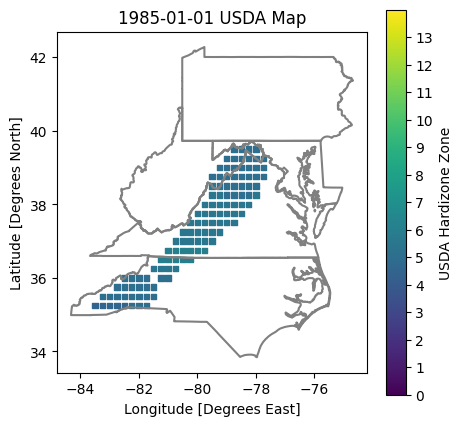

In [ ]:
us_boundary_map = east.boundary.plot(figsize=(5, 5), color="Gray")
overlayed.plot(ax = us_boundary_map,column = 'usda_zone', marker = 's',markersize=15, legend = True,
            legend_kwds={"label": "USDA Hardizone Zone", "orientation": "vertical", 'ticks':[i for i in range(0,14)]},vmin = 0,vmax = 14)

plt.xlabel('Longitude [Degrees East]')
plt.ylabel('Latitude [Degrees North]')
plt.title('1985-01-01 USDA Map')

Time Horizon

In [ ]:
dates = list(set([i[0] for i in zones.index]))

# https://stackoverflow.com/questions/42462935/how-to-sort-by-timestamps-in-pandas
dates = pd.to_datetime(dates, format="%Y%m%d:%H:%M:%S.%f").sort_values().to_list()

In [ ]:
fig, [ax,cax] = plt.subplots(1, 2, figsize = (10,5), gridspec_kw={"width_ratios":[50,1]})

cmap = cm.ScalarMappable(Normalize(0, 14))#, colors)

#Create the colorbar with colormap
plt.colorbar(mappable = cmap, cax = cax)
cax.set_title('USDA Hardiness Zone')

#We'll pass this function to FuncAnimation to create the animation
def plot_frame(ts):

    gdf2 = gdf.loc[dates[ts]]

    
    ax.set_title('Eastern US USDA Hardiness Zones: {}'.format(dates[ts]))
    ax.set_xlabel('longitude')
    ax.set_ylabel('latitude')
    
    east.plot(color = 'grey', ax = ax) 
    overlayed = gpd.overlay(east_orchards_gdf, gdf_1985, how='intersection',keep_geom_type=False)
    overlayed.plot(ax =ax,column = 'usda_zone', marker = 's',markersize=15, 
            legend_kwds={"label": "USDA Hardizone Zone", "orientation": "vertical", 'ticks':[i for i in range(0,14)]}
            ,vmin = 0,vmax = 14)
            
    plt.close()

# To solve for the interval argument in FuncAnimation
# TBD.

anim = FuncAnimation(fig, plot_frame,  
                    frames = range(0,len(dates)),
                    #frames = range(0,2),
                    interval = 200)


HTML(anim.to_jshtml())

In [ ]:
# save to disk
anim.save('../assets/weather_usda.gif', writer='pillow')